<a href="https://colab.research.google.com/github/Astha32/News-Headline-Generation/blob/main/seq2seq_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy import data
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np
import matplotlib.pyplot as plt

import random
import math
import time

In [2]:
torch.cuda.is_available()

True

## Preparing Data:

The dataset prepared from raw BBC headlines data is used as input for the model.

The data is preprocessed using torchtext and tokenisation is carried out using spaCy. The training and validation iterators are created using BucketIterator.


In [3]:
SEED = 23

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
spacy_en = spacy.load('en_core_web_sm')

In [5]:
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [6]:
TXT = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


In [7]:
fields = [('Cleaned_Article', TXT), ('Cleaned_Headline', TXT)]

In [8]:
vocab_data = data.TabularDataset(
                            path = '/content/BBCNewsDataComplete.csv',
                            format = 'csv',
                            fields = fields)


In [9]:
train_data= data.TabularDataset(
                            path = '/content/BBCnews_trainset.csv',
                            format = 'csv', 
                            fields = fields)


In [10]:
val_data = data.TabularDataset(
                            path = '/content/BBCnews_testset.csv',
                            format = 'csv', 
                            fields = fields)

In [11]:
import torchtext.vocab 

In [12]:
TXT.build_vocab(vocab_data)

In [13]:
# Build vocabulary and use pretrained fasttext embeddings (observation: model performance gone down)
# TXT.build_vocab(vocab_data,
#                 max_size=25000,
#                 min_freq=2,
#                 vectors='fasttext.simple.300d',
#                 unk_init=torch.Tensor.normal_)


1146

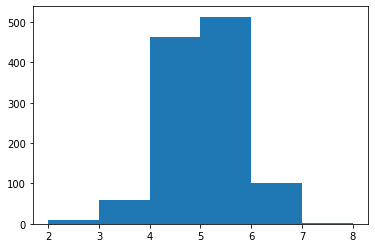

In [14]:
dta = [len(i.Cleaned_Headline) for i in train_data]
plt.hist(dta, bins=np.arange(min(dta), max(dta)+1))
len(train_data)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
BATCH_SIZE = 16

train_iterator = BucketIterator(
    train_data, 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x : len(x.Cleaned_Article),
    device = device)

In [17]:
valid_iterator = BucketIterator(
    val_data, 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x : len(x.Cleaned_Article),
    device = device)

## Seq2Seq Model with Attention:



*   Encoder: It is a 2 layer bidirectional GRU. The input article is embedded using the embedding layer and then dropout layer is applied. The obtained embedded vectors are passed into RNN which returns outputs(top layer hidden state) and hidden states of each layer.
*   Attention layer: The previous hidden state of decoder and the encoder outputs are supplied as input to obtain attention vector that represents which words in the source sentence should be paid the most attention in order to predict the next word to decode. The weighted source vector is created using the attention vector.



*   Decoder: It is a 1 layer unidirectional GRU. The previous hidden state of decoder, weighted source vector and the embedded input word are supplied as input to the RNN to obtain the next predicted word in the target headline.



*   Seq2Seq: It encapsulates the encoder and decoder and will provide a way to interface with each. It receives the input sentence(news article) and passes it to encoder to produce the context vectors. The target headline and the encoder outputs are then passed to the decoder to produce the predicted headline.




In [64]:
class Encoder(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, emb_dim, shared_embedding, num_layers=2, dropout=0.0):
        super().__init__()
        
        self.embedding = shared_embedding
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim,  num_layers=2, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src_len = [batch size]
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))

        #embedded = [src len, batch size, emb dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
        
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [65]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim=1)

In [66]:
class Decoder(nn.Module):
    def __init__(self, output_dim, shared_embedding, emb_dim, enc_hid_dim, 
                 dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = shared_embedding
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [67]:
class Seq2Seq(nn.Module):
    def __init__(self, output_dim, embedding_size, vocab_size, enc_hidden_size, dec_hidden_size,
                 src_pad_idx, enc_dropout, dec_dropout, device):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        self.attention = Attention(enc_hidden_size, dec_hidden_size)

        self.encoder = Encoder(enc_hidden_size, dec_hidden_size, embedding_size, self.embedding, num_layers=2, dropout=enc_dropout)
        
        self.decoder = Decoder(output_dim, self.embedding, embedding_size, enc_hidden_size, dec_hidden_size, dropout=dec_dropout,attention=self.attention )
        
        self.device = device
        self.src_pad_idx = src_pad_idx

    def create_mask(self, src):
      mask = (src != self.src_pad_idx).permute(1, 0)
      return mask
        
    def forward(self, src, src_len, trg, trg_len, teacher_forcing_ratio = 0.0):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio = probability to use teacher forcing
        
        batch_size = src.shape[1]
        # trg_len = trg.shape[0]
        target_len = max(trg_len)
        trg_vocab_size = self.decoder.output_dim
        # outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        outputs = torch.zeros(target_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        mask = self.create_mask(src)
        
        for t in range(1, target_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

Training the model

In [68]:

Embedding_size = 256
Vocab_size = len(TXT.vocab)
Enc_hidden_size = 512
Dec_hidden_size = 512
Enc_dropout = 0.5
Dec_dropout = 0.5
pad_idx = TXT.vocab.stoi[TXT.pad_token]
model = Seq2Seq(Vocab_size, Embedding_size, Vocab_size, Enc_hidden_size, Dec_hidden_size,
                 pad_idx, Enc_dropout, Dec_dropout, device).to(device)

# pretrained_embeddings = TXT.vocab.vectors
# model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TXT.vocab.stoi[TXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(Embedding_size)
model.embedding.weight.data[pad_idx] = torch.zeros(Embedding_size)
model.embedding.weight.requires_grad = True



In [69]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (embedding): Embedding(21696, 256)
  (attention): Attention(
    (attn): Linear(in_features=1536, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (encoder): Encoder(
    (embedding): Embedding(21696, 256)
    (rnn): GRU(256, 512, num_layers=2, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(21696, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=21696, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [70]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 55,613,120 trainable parameters


In [71]:
optimizer = optim.Adam(model.parameters())

In [72]:
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)

In [73]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.Cleaned_Article
        trg, trg_len = batch.Cleaned_Headline
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg, trg_len)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [74]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.Cleaned_Article
            trg, trg_len = batch.Cleaned_Headline

            output = model(src, src_len, trg, trg_len, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [75]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [76]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
torch.save(model.state_dict(), 'seq2seq-model.pt')
    

Epoch: 01 | Time: 0m 35s
	Train Loss: 8.276
Epoch: 02 | Time: 0m 35s
	Train Loss: 6.466
Epoch: 03 | Time: 0m 35s
	Train Loss: 6.122
Epoch: 04 | Time: 0m 35s
	Train Loss: 5.835
Epoch: 05 | Time: 0m 35s
	Train Loss: 5.510
Epoch: 06 | Time: 0m 35s
	Train Loss: 5.082
Epoch: 07 | Time: 0m 35s
	Train Loss: 4.611
Epoch: 08 | Time: 0m 35s
	Train Loss: 4.135
Epoch: 09 | Time: 0m 35s
	Train Loss: 3.620
Epoch: 10 | Time: 0m 35s
	Train Loss: 3.068


In [77]:
model.load_state_dict(torch.load('seq2seq-model.pt'))

<All keys matched successfully>

In [78]:
test_loss = evaluate(model, valid_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 9.266


# Inference:

The trained model is used for generating the headlines.

The input news articles are tokenised and passed to the model in evaluation mode. 
The predicted output sentence is converted from indexes to tokens.



In [85]:

def summarise_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    nlp = spacy.load('en')
    tokens = [token.text.lower() for token in nlp(sentence)]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    print(tokens)
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention

        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [86]:
example_idx = 12

src = vars(train_data.examples[example_idx])['Cleaned_Article']
trg = vars(train_data.examples[example_idx])['Cleaned_Headline']

print(f'src = {src}')
print(f'trg = {trg}')
src1 = ""
for tok in src:
  src1+=(tok)+" "
print(src1)
summarisation, attention = summarise_sentence(src1, TXT, TXT, model, device)

print(f'predicted trg = {summarisation}')

src = ['soaring', 'oil', 'sales', 'and', 'budget', 'surplus', 'mean', 'russian', 'debt', 'longer', 'risky', 'investment', 'one', 'the', 'world', 'leading', 'credit', 'rating', 'agencies', 'says', 'standard', 'poor', 'has', 'classed', 'russian', 'bonds', 'investment', 'grade', 'from', 'their', 'former', 'speculative', 'rating', 'russia', 'reputation', 'among', 'investors', 'has', 'been', 'hurt', 'recent', 'months', 'the', 'heavy', 'tax', 'bills', 'and', 'asset', 'seizures', 'imposed', 'companies', 'such', 'oil', 'giant', 'yukos', 'said', 'the', 'solidity', 'government', 'finances', 'outweighed', 'the', 'risk', 'russia', 'now', 'net', 'creditor', 'rather', 'than', 'debtor', 'gold', 'and', 'foreign', 'currency', 'reserves', 'beat', 'its', 'foreign', 'public', 'debt', 'some', 'the', 'other', 'two', 'major', 'ratings', 'agencies', 'fitch', 'and', 'moody', 'have', 'long', 'since', 'upped', 'their', 'rating', 'russia', 'sovereign', 'debt', 'had', 'held', 'back', 'through', 'fear', 'that', 'th

In [87]:
example_idx = 70

src1 = vars(val_data.examples[example_idx])['Cleaned_Article']
trg1 = vars(val_data.examples[example_idx])['Cleaned_Headline']

print(f'src = {src1}')
print(f'trg = {trg1}')
test_src = ""
for tok in src1:
  test_src+=(tok)+" "
print(test_src)
summary_test, attention_test = summarise_sentence(test_src, TXT, TXT, model, device)

print(f'predicted trg = {summary_test}')

src = ['microsoft', 'investigating', 'trojan', 'program', 'that', 'attempts', 'switch', 'off', 'the', 'firm', 'anti', 'spyware', 'software', 'the', 'spyware', 'tool', 'was', 'only', 'released', 'microsoft', 'the', 'last', 'few', 'weeks', 'and', 'has', 'been', 'downloaded', 'six', 'million', 'people', 'stephen', 'toulouse', 'security', 'manager', 'microsoft', 'said', 'the', 'malicious', 'program', 'was', 'called', 'bankash', 'trojan', 'and', 'was', 'being', 'sent', 'mail', 'attachment', 'microsoft', 'said', 'did', 'not', 'believe', 'the', 'program', 'was', 'widespread', 'and', 'recommended', 'users', 'use', 'anti', 'virus', 'program', 'the', 'program', 'attempts', 'disable', 'delete', 'microsoft', 'anti', 'spyware', 'tool', 'and', 'suppress', 'warning', 'messages', 'given', 'users', 'may', 'also', 'try', 'steal', 'online', 'banking', 'passwords', 'other', 'personal', 'information', 'tracking', 'users', 'keystrokes', 'microsoft', 'said', 'statement', 'investigating', 'what', 'called', 'c